In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import warnings
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import random_split
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from tqdm import tqdm
from IPython.display import clear_output

In [2]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, Compose
from torch.utils.data import random_split
from PIL import Image

class CatDataset(Dataset):
    def __init__(self, root_dir: str):
        self.root_dir = root_dir
        self.file_list = os.listdir(self.root_dir)
        self.transform = Compose([ToTensor()])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_file = self.file_list[index]
        img_path = os.path.join(self.root_dir, img_file)
        
        # image = Image.open(img_path)
        #return self.transform(image)

        return torch.load(img_path, weights_only=True)

In [3]:
dataset = CatDataset('/kaggle/input/diffusion-2/cat_dataset/kaggle/working/dataset')
generator = torch.Generator().manual_seed(239)
torch.manual_seed(42)
data_train, data_test = random_split(dataset, [len(dataset) - int(1e4), int(1e4)], generator)

train_dataloader = DataLoader(data_train, batch_size=1024, shuffle=True)
test_dataloader = DataLoader(data_test, batch_size=1024, shuffle=True)

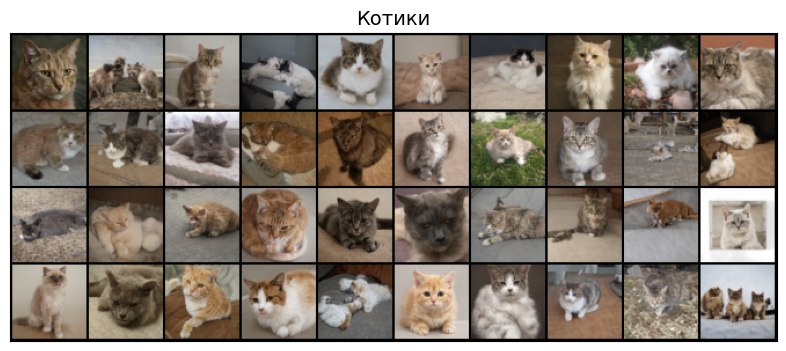

In [4]:
from torchvision.utils import make_grid

def remove_ticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=False,
        labelleft=False
    )

def remove_xticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=True,
        labelleft=True
    )

def visualize_batch(img_vis, title='Семплы из цветного MNIST', nrow=10, ncol=4):
    img_grid = make_grid(img_vis, nrow=nrow)
    fig, ax = plt.subplots(1, figsize=(nrow, ncol))
    remove_ticks(ax)
    ax.set_title(title, fontsize=14)
    ax.imshow(img_grid.permute(1, 2, 0))
    plt.show()

batch = next(iter(train_dataloader))
visualize_batch(batch[:40], title='Котики')

In [5]:
!git clone https://github.com/NVlabs/edm

Cloning into 'edm'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 54 (delta 13), reused 13 (delta 13), pack-reused 20 (from 1)
Receiving objects: 100% (54/54), 2.13 MiB | 14.13 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [6]:
import sys
sys.path.append('edm')
sys.path.append('edm/training/')
sys.path.append('edm/training/networks')
sys.path.append('/kaggle/input/diffusion-2')

In [7]:
import pickle
from edm.dnnlib import util
from torch_utils import misc
from cunet import CUNet

# внести в файл cunet.py
class EDMPrecond(nn.Module):
    def __init__(self, model, sigma_data=0.5):
        super().__init__()
        self.sigma_data = sigma_data
        self.model = model

    def forward(self, x, sigma, class_labels=None):
        sigma = sigma.reshape(-1, 1, 1, 1)

        c_skip = self.sigma_data ** 2 / (sigma ** 2 + self.sigma_data ** 2)
        c_out = sigma * self.sigma_data / (sigma ** 2 + self.sigma_data ** 2).sqrt()
        c_in = 1 / (self.sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4

        F_x = self.model(
            (c_in * x).type(torch.float32), 
            c_noise.flatten().type(torch.float32), 
            class_labels=None if class_labels is None else class_labels.type(torch.float32)
        )
        D_x = c_skip * x + c_out * F_x
        return D_x

cunet = CUNet(in_channels=3, out_channels=3, noise_channels=128, base_factor=64, emb_channels=128)
cunet = EDMPrecond(cunet)
cunet.load_state_dict(torch.load('/kaggle/input/diffusion-2/cunet.pt', weights_only=True))
cunet_ddp = torch.nn.DataParallel(cunet, device_ids=[0, 1])

In [35]:
#x1 -- corrupt, x0 -- real
def corruption(x):
    return transforms.functional.gaussian_blur(x, 7, 2)

class I2SB():
    def __init__(self, cunet, betas, device='cuda', corruption_fn=corruption, stochastic=True, add_noise_to_x1=False):
        self.cunet = cunet.to(device)
        self.corruption = corruption_fn
        self.num_steps = len(betas)
        self.device = device

        self.betas = betas.to(device)
        self.sigmas2 = torch.cumsum(betas, dim=0).to(device)
        self.sigmas = torch.sqrt(self.sigmas2).to(device)
        self.over_sigmas2 = betas.sum() - torch.cat((torch.tensor([0], device=device), self.sigmas2[:-1]), dim=0).to(device)
        
        self.mus_t0 = self.over_sigmas2 / (self.sigmas2 + self.over_sigmas2).to(device)
        self.mus_t1 = self.sigmas2 / (self.sigmas2 + self.over_sigmas2).to(device)
        self.var = (self.sigmas2 * self.over_sigmas2) / (self.sigmas2 + self.over_sigmas2).to(device)
        
        self.stochastic = stochastic
        self.add_noise_to_x1 = add_noise_to_x1

    def get_pred_x0(self, xt, step):
        eps = self.cunet(xt, self.sigmas[step])
        x0 = xt - eps * self.sigmas[step].view(-1, 1, 1, 1)
        return x0

    def get_xt(self, x0, x1, steps):
        xt = self.mus_t0[steps].view(-1, 1, 1, 1) * x0 + self.mus_t1[steps].view(-1, 1, 1, 1) * x1
        if self.stochastic:
            xt = xt + torch.sqrt(self.var[steps].view(-1, 1, 1, 1)) * torch.randn_like(xt)
        return xt

    def get_xt_from_sigmas(self, x0, x1, sigma2, over_sigma2, ind):
        mus_t0 = over_sigma2 / (sigma2 + over_sigma2)
        mus_t1 = sigma2 / (sigma2 + over_sigma2)
        
        xt = mus_t0 * x0 + mus_t1 * x1
        
        if ind > 0 and self.stochastic:
            var = (over_sigma2 * sigma2) / (sigma2 + over_sigma2)
            xt += torch.sqrt(var) * torch.randn_like(xt)

        return xt

    def get_next_xt(self, xt_now, x0, step_now, step_next, ind):
        sigma2 = self.sigmas2[step_next]
        over_sigma2 = self.sigmas2[step_now] - self.sigmas2[step_next]

        return self.get_xt_from_sigmas(x0, xt_now, sigma2, over_sigma2, ind)

    def sampling(self, x1, steps):
        xt_now = x1
        trajectory = [x1]
        
        with torch.no_grad():
            for i in range(len(steps) - 1, 0, -1):
                step = steps[i] * torch.ones((xt_now.shape[0], 1, 1, 1), dtype=int, device=self.device)
                
                x0 = self.get_pred_x0(xt_now, step)
                xt_now = self.get_next_xt(xt_now, x0, steps[i], steps[i - 1], i - 1)
                trajectory.append(xt_now)

        return xt_now, trajectory

    def loss(self, x0, x1):
        steps = torch.randint(low=0, high=self.num_steps, size=(x0.shape[0],), device=x1.device)
        xt = self.get_xt(x0, x1, steps)
        eps = self.cunet(xt, self.sigmas[steps])

        return torch.mean(torch.square(eps - (xt - x0) / self.sigmas[steps].view(-1, 1, 1, 1)))

    def visualize_training(self, x0, x1, loss_history):
        self.cunet.eval()
        clear_output(wait=True)
        
        visualize_batch(x1[0:10].cpu() * 0.5 + 0.5, title='corrupt')
        visualize_batch(self.sampling(x1[0:10], np.arange(0, self.num_steps, 1))[0].cpu() * 0.5 + 0.5, title='predictions')
        visualize_batch(x0[0:10].cpu() * 0.5 + 0.5, title='original')
    
        #visualize_training(model, loss_history, log_imgs, sampling_params, cond=y)
        plt.plot(np.arange(len(loss_history)), loss_history)
        plt.yscale('log')
        # plt.ylim(0, 5)
        plt.grid(True)
        plt.title('Лосс на обучении', fontsize=17)
        plt.xlabel('Итерация', fontsize=14)
        plt.tick_params(labelsize=13)
        plt.plot(loss_history)
        plt.show()

    def train(self, opt, train_dataloader, n_epochs, eval_every=100, loss_before=None):
        loss_history = [] if loss_before is None else loss_before
        iter = 0
        with tqdm(total=len(train_dataloader) * n_epochs) as pbar:
            for epoch in range(n_epochs):
                for batch in train_dataloader:
                    self.cunet.train()
                    opt.zero_grad()
                    x0 = (batch * 2 - 1).to(self.device)
                    x1 = self.corruption(x0) #(batch['A'] * 2 - 1).to(self.device)
                    
                    if self.add_noise_to_x1:
                        x1 += torch.randn_like(x1)
                    
                    loss = self.loss(x0, x1)
                    loss.backward()
                    loss_history.append(loss.item())
                    opt.step()
    
                    if eval_every > 0 and iter % eval_every == 0:
                        self.visualize_training(x0, x1, loss_history)
    
                    pbar.update(1)
                    pbar.set_description('Loss: %.4g' % loss.item())
                    iter += 1

                if (epoch + 1 ) % 10 == 0:
                    checkpoint = { 
                        'epoch': 40 + epoch,
                        'model': model.cunet.state_dict(),
                        'optimizer': opt.state_dict(), 
                        'loss_history': loss_history}
                    torch.save(checkpoint, f'checkpoint_fix_blur_cat_{40 + epoch}_epoch.pth')

        self.visualize_training(x0, x1, loss_history)
        print(f'Loss={loss_history[-1]}')

        return loss_history

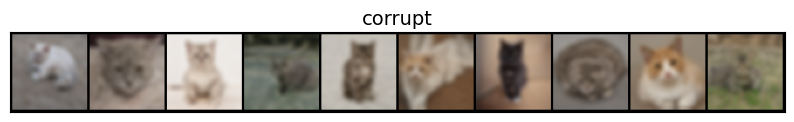

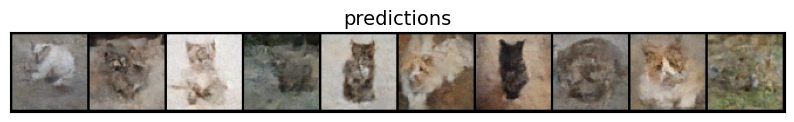

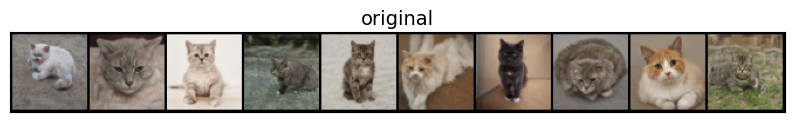

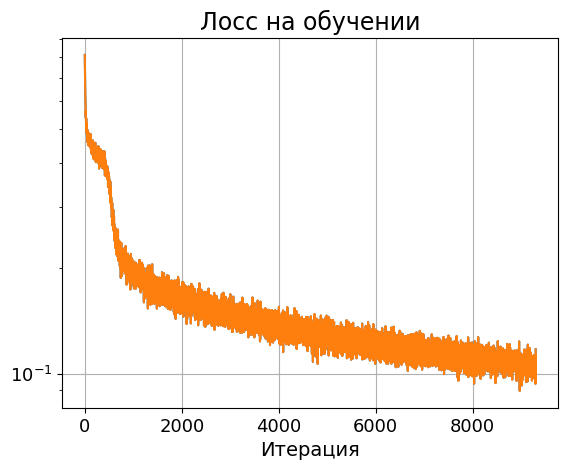

Loss=0.11765866161103566


In [18]:
n_timesteps=100
linear_start=1e-4
linear_end=2e-2
betas = np.linspace(linear_start ** 0.5, linear_end ** 0.5, n_timesteps, dtype=np.float64) ** 2
betas = torch.tensor(np.concatenate([betas[:n_timesteps//2], np.flip(betas[:n_timesteps//2])]))

model=I2SB(cunet_ddp, betas, device='cuda')

params = [p for p in model.cunet.parameters() if p.requires_grad]
opt = torch.optim.AdamW(params, lr=5e-5)
epoches = 30

loss_history = model.train(opt, train_dataloader, epoches, eval_every=100, loss_before=loss_before)